<a href="https://colab.research.google.com/github/celaira/roof_deep_learning/blob/main/dida_testtask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Images:**

### Mount Google Drive:
Einrichten von Google Drive, um auf den dort gespeicherten Datensatz zuzugreifen.

**!!! Please make sure, that your training-, testimages and labels are saved separately AND on the right path, or change the path definition below. !!!**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Packages:
Importieren von erforderlichen Bibliotheken für die Bildverarbeitung, Modellerstellung und Auswertung.

In [2]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, InputLayer


### Create path to data:
Definieren von Pfade zu den Trainingsbildern, Labels und Testbildern.

In [3]:
training_image_path = '/content/drive/MyDrive/training_image'
label_path = '/content/drive/MyDrive/label'
test_image_path = '/content/drive/MyDrive/test_image'

### Import the images:

`def load_images_from_folder(folder):`

Definition einer Funktion zum (Herunter-) laden von Bildern.

`load_images_from_folder(training_image_path)`

Dann diese Funktion verwenden zum Laden von Trainings-, Labels- und Testbildern.

`sorted(train_image_filenames)`

`[cv.imread(os.path.join(training_image_path, filename)) for filename in train_image_filenames_sorted]`

Sortierung die Dateinamen der Trainingsbilder und der Labels (alphabetisch) und liest dann die Bilder und Labels in derselben Reihenfolge ein. Dies stellt sicher, dass jedes Trainingsbild mit dem richtigem Label gepaart ist, damit
das Modell korrekt trainiert wird.

`cv.IMREAD_GRAYSCALE`

Dies sorgt dafür, dass die Labels in Graustufen eingelesen werden.

`np.array()`

Bilddaten zu NumPy-Arrays konvertieren. Dies ist nützlich, da NumPy-Arrays effizienter verarbeitet werden können und viele maschinelle Lernbibliotheken wie TensorFlow oder Keras NumPy-Arrays als Eingabe erwarten.

`aligned_train_images / 255.0`

Normalisieren der Pixel der Bilder. Dadurch werden die Pixelwerte auf den Bereich von 0 bis 1 skaliert. Für die Stabilisierung und Beschleunigung des Trainings und zur Verbesserung der Modellgenauigkeit aufgrund des nun konsistenten und kleineren Wertebereich.

In [4]:
def load_images_from_folder(folder):
    images = []
    filenames = sorted(os.listdir(folder))
    for filename in filenames:
        img = cv.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return np.array(images), filenames

train_images, train_image_filenames = load_images_from_folder(training_image_path)
labels, label_filenames = load_images_from_folder(label_path)
test_images, test_image_filenames = load_images_from_folder(test_image_path)

train_image_filenames_sorted = sorted(train_image_filenames)
label_filenames_sorted = sorted(label_filenames)
aligned_train_images = [cv.imread(os.path.join(training_image_path, filename)) for filename in train_image_filenames_sorted]
aligned_labels = [cv.imread(os.path.join(label_path, filename), cv.IMREAD_GRAYSCALE) for filename in label_filenames_sorted]

aligned_train_images = np.array(aligned_train_images)
aligned_labels = np.array(aligned_labels)
test_images = np.array(test_images)

aligned_train_images = aligned_train_images / 255.0
aligned_labels = aligned_labels / 255.0
test_images = test_images / 255.0


### Creating validation data:
`np.where(aligned_labels > 0.5, 1, 0):`

Dieser Befehl binarisiert die Labels. Alle Werte über 0.5 werden auf 1 gesetzt, alle anderen auf 0.

`aligned_train_images[..., np.newaxis]`

 Den Daten eine zusätzliche Dimension hinzufügen, um sie an den vom Modell erwartete Input anzupassen.

 `train_test_split(aligned_train_images, aligned_labels, test_size=0.2, random_state=42)`

Aufteilen der Trainingsdaten in Trainings- und Validierungsdaten.

In [5]:
aligned_labels = np.where(aligned_labels > 0.5, 1, 0)

aligned_train_images = aligned_train_images[..., np.newaxis]
aligned_labels = aligned_labels[..., np.newaxis]
test_images = test_images[..., np.newaxis]

train_images, val_images, train_labels, val_labels = train_test_split(aligned_train_images, aligned_labels, test_size=0.2, random_state=42)

# **Define a UNET-Model:**

`def unet_model(input_shape):`

Definiert eine Funktion zur Erstellung des U-Net Modells mit der Eingabeform input_shape, was die Form der Eingabebilder definiert (z. B. Höhe, Breite, etc.).

`layers.Input(shape=input_shape)`

Erstellt einen Keras-Tensor, der als Eingabeebene des Modells fungiert. Die Form dieser Eingabe wird durch input_shape definiert.

**Encoder:**

Der Encoder-Teil des U-Net ist verantwortlich für das Extrahieren von Features aus den Images und das Reduzieren der räumlichen Dimensionen. Dies geschieht durch die folgenden Blöcke, die jeweils aus zwei Convolutional Layers und einer MaxPooling-Schicht bestehen. Mehrere Faltungsschichten hintereinander ermöglichen es dem Modell, komplexere Merkmale zu lernen.

Nun Anwenden von Filtern auf das Bild um Merkmale zu extrahieren.
Verwenden von Aktivierungsfunktionen wie ReLU, um die Modellleistung zu verbessern.

`layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)`

Erste Convolutional Layer (2D) mit 64 Filtern und ReLU-Aktivierung, angewendet auf inputs. Dabei stellt padding='same' sicher, dass der Output die gleiche Breite und Höhe wie der Input hat.

`layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1):`

Zweite Convolutional Layer (2D), angewendet auf die Ausgabe der Ersten.

`layers.MaxPooling2D((2, 2))(c1)`

Reduzieren der räumlichen Dimensionen, sodass auf die wichtigsten Merkmale fokussiert wird, indem die höchsten Werte innerhalb kleiner Regionen beibehalten werden.

**Bottleneck:**

 Im Bottleneck-Teil sind die Feature Maps maximal komprimiert, also ist die Dimension klein, aber die Anzahl der Kanäle hoch ist. Dies ermöglicht es dem Modell, tiefgreifende, komprimierte Merkmale zu lernen, bevor die Auflösung wieder erhöht wird in Decoder.

**Decoder:**

Der Decoder-Teil kehrt die Operationen des Encoders um, stellt somit die räumlichen Dimensionen des ursprünglichen Bildes wieder her, während die extrahierten Merkmale integriert werden.

`layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)`

Erhöhen der räumlichen Dimensionen der Feature Maps.

`layers.concatenate([u6, c4])`

Kombiniert/ Verkettet die hochgesampelten Features mit den Features aus der entsprechenden Ebene des Encoders.

`layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(u7):`

Anwenden von weiteren Faltungsschichten auf die kombinierten Feature Maps, um die Features zu verfeinern.

`layers.Conv2D(2, (1, 1), activation='softmax')(c11)`

Letzte Convolutional Layer mit 2 Filtern und Softmax-Aktivierung. Die Softmax-Funktion wird verwendet, um eine Wahrscheinlichkeitsverteilung über die möglichen Klassen zu erzeugen.

`models.Model(inputs=[inputs], outputs=[outputs])`

 Erstellt nun das Modell mit den angegebenen Input- und Outputschichten.

In [9]:
# Define the U-Net model
def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(2, (1, 1), activation='softmax')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# **Train Model:**

`input_shape =...`

Bestimmt die Form der Input-Train_Images.

`unet_model(input_shape)`

Erstellt das U-Net Modell.

`model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])`

Kompiliert das Modell mit Adam-Optimizer und categorical_crossentropy als Verlustfunktion.

`num_classes = 2`

Zwei Klassen: Dach und Nicht-Dach

`model.fit(train_images, train_labels_cat, epochs=20, batch_size=5, validation_data=(val_images, val_labels_cat))`

Trainiert das Modell mit den angegebenen Trainingsdaten und Validierungsdaten
`epochs=20` gibt die Anzahl der Trainingsepochen an. Eine Epoche ist ein vollständiger Durchlauf durch den gesamten Trainingsdatensatz.
`batch_size=5`: Die Batch-Größe bestimmt, wie viele Trainingsbeispiele das Modell auf einmal verarbeitet.

Dabei werden auch noch die Validierungsdaten angegeben, die während des Trainings verwendet werden sollen, um die Leistung des Modells zu überwachen.

`model.save()`

Speichert trainiertes Modell ab.

In [16]:
input_shape = (train_images.shape[1], train_images.shape[2], train_images.shape[3])
model = unet_model(input_shape)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
num_classes = 2
train_labels_cat = to_categorical(train_labels, num_classes=num_classes)
val_labels_cat = to_categorical(val_labels, num_classes=num_classes)
history = model.fit(train_images, train_labels_cat, epochs=20, batch_size=5, validation_data=(val_images, val_labels_cat))
model.save('/content/drive/MyDrive/save')
#val_loss, val_accuracy = model.evaluate(val_images, val_labels)

Epoch 1/20
4/4 [==============================] - 8s 527ms/step - loss: 0.5823 - accuracy: 0.8511 - val_loss: 0.4576 - val_accuracy: 0.8615
Epoch 2/20
4/4 [==============================] - 1s 323ms/step - loss: 0.4852 - accuracy: 0.8527 - val_loss: 0.4401 - val_accuracy: 0.8615
Epoch 3/20
4/4 [==============================] - 1s 343ms/step - loss: 0.4554 - accuracy: 0.8527 - val_loss: 0.4038 - val_accuracy: 0.8615
Epoch 4/20
4/4 [==============================] - 1s 327ms/step - loss: 0.4081 - accuracy: 0.8527 - val_loss: 0.3768 - val_accuracy: 0.8615
Epoch 5/20
4/4 [==============================] - 1s 338ms/step - loss: 0.4159 - accuracy: 0.8527 - val_loss: 0.3778 - val_accuracy: 0.8615
Epoch 6/20
4/4 [==============================] - 1s 316ms/step - loss: 0.4517 - accuracy: 0.8527 - val_loss: 0.4562 - val_accuracy: 0.8615
Epoch 7/20
4/4 [==============================] - 1s 334ms/step - loss: 0.4260 - accuracy: 0.8527 - val_loss: 0.3755 - val_accuracy: 0.8615
Epoch 8/20
4/4 [====

# **Predictions and Visualization of them :**


`predictions_path = '/content/drive/MyDrive/predictions'`

`os.makedirs(predictions_path, exist_ok=True)`

Definiert den Pfad für die Abspeicherung der Predictions und erstellt das Verzeichnis für die Predictions, falls es nicht existiert.

`np.argmax(pred, axis=-1):`

`(pred_mask * 255).astype(np.uint8):`

Konvertiert die Wahrscheinlichkeiten in class labels und die Masken in 8-Bit Integer.

`np.squeeze(pred_mask): `

Stellt sicher, dass ... (die Maske ein einzelner Kanal ist).

`cv.imwrite(os.path.join(predictions_path, f'prediction_{i}.png'), mask)`

Speichert die Masken als Bilder ?

`plt.figure(figsize=(15, 15)):`

`plt.subplot(num, 3, i*3 + 1)` bzw. `plt.subplot(nrows, ncols, index)`

Erstellt Plot und ein Raster aus Subplots für die Testbilder.

`plt.imshow()`

Zeigt die Bilder und Masken an.

`plt.tight_layout()`

Sorgt für eine saubere Anordnung der Subplots.

`plt.show()`

Zeigt den Plot an.

`display_predictions(test_images, predictions, num=5)`

Zeigt die Predictions für die  5 Testbilder an.

1/1 [==============================] - 0s 234ms/step


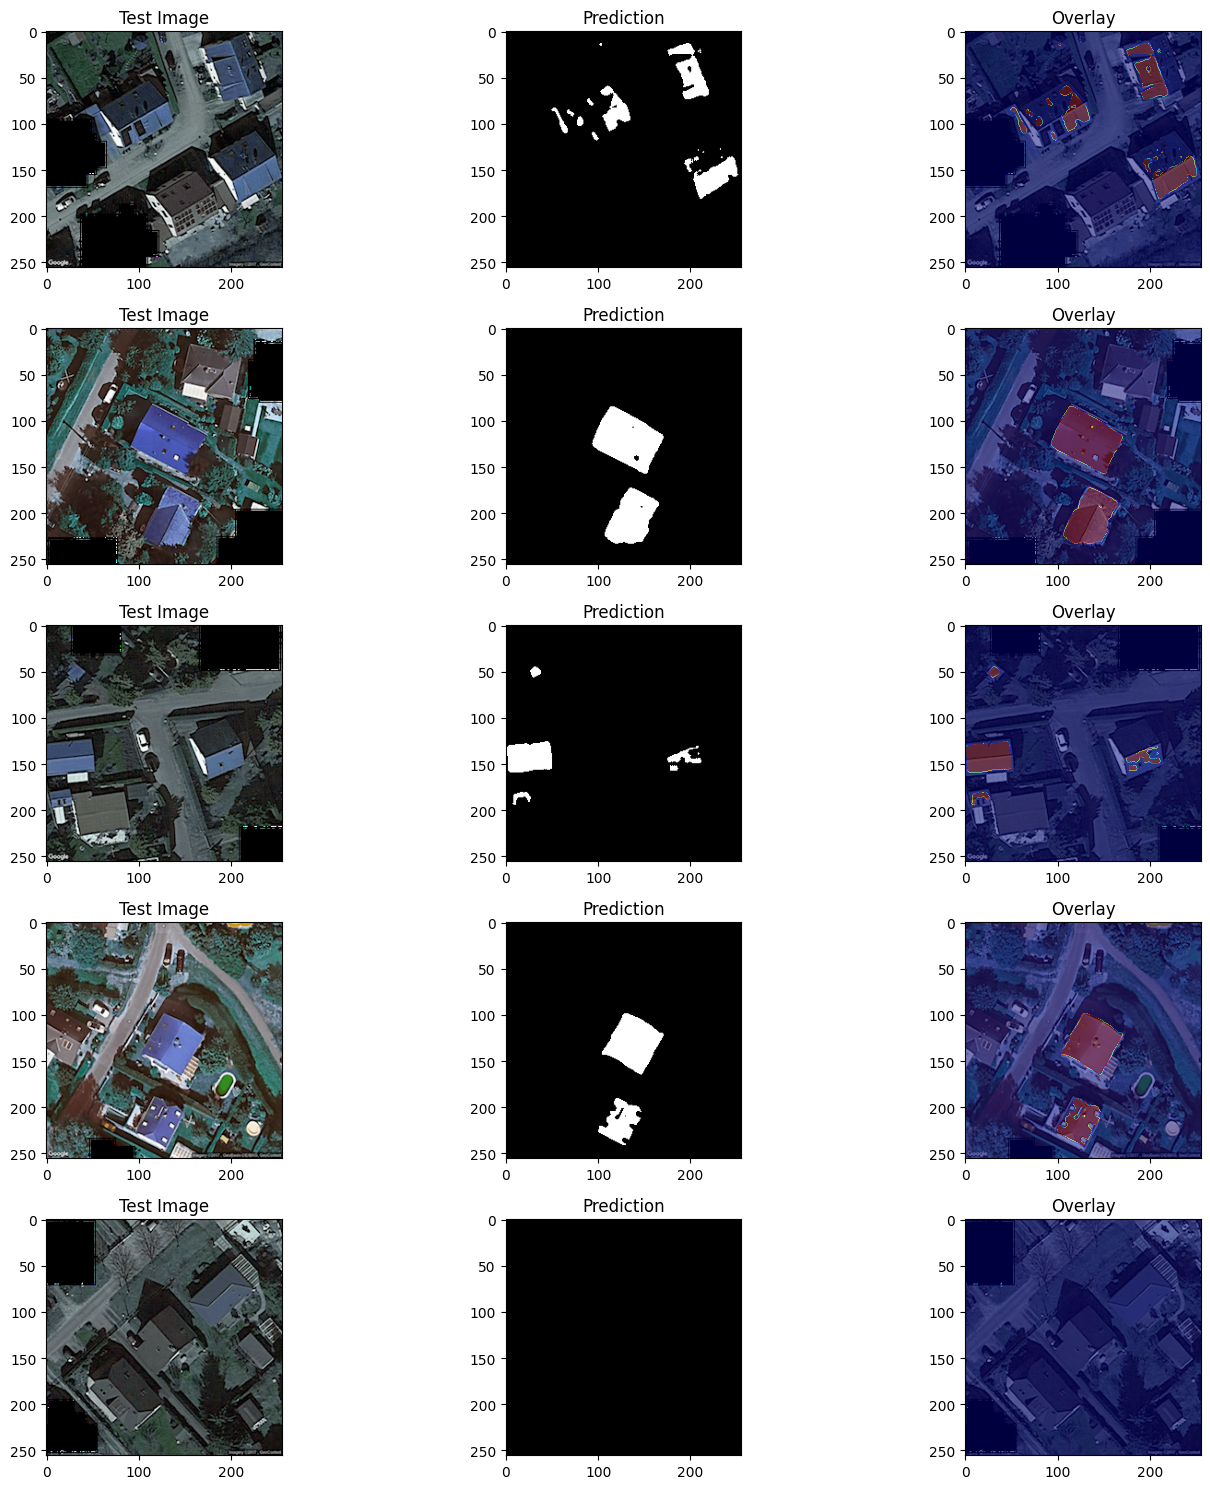

In [17]:
predictions = model.predict(test_images)
predictions_path = '/content/drive/MyDrive/predictions'
os.makedirs(predictions_path, exist_ok=True)

for i, pred in enumerate(predictions):
    mask = np.argmax(pred, axis=-1)
    mask = (mask * 255).astype(np.uint8)
    mask = np.squeeze(mask)
    cv.imwrite(os.path.join(predictions_path, f'prediction_{i}.png'), mask)

def display_predictions(test_images, predictions, num=5):
    plt.figure(figsize=(15, 15))
    for i in range(num):
        plt.subplot(num, 3, i*3 + 1)
        plt.imshow(test_images[i].squeeze(), cmap='gray')
        plt.title("Test Image")

        plt.subplot(num, 3, i*3 + 2)
        mask = np.argmax(predictions[i], axis=-1)
        plt.imshow(mask, cmap='gray')
        plt.title("Prediction")

        plt.subplot(num, 3, i*3 + 3)
        plt.imshow(test_images[i].squeeze(), cmap='gray')
        plt.imshow(mask, cmap='jet', alpha=0.5)
        plt.title("Overlay")

    plt.tight_layout()
    plt.show()

display_predictions(test_images, predictions, num=5)